In [1]:
# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pandas as pd

In [2]:
df = pd.read_csv(r"../data/adult_income.csv")

In [4]:
print(df.shape)
print(df.head())
print(df.info())
print(df.describe(include='all'))

# Check target distribution
print(df.columns.tolist())


(1664500, 12)
   AGEP  COW  SCHL  MAR    OCCP  POBP  RELP  WKHP  SEX  RAC1P   ST    PINCP
0  18.0  1.0  18.0  5.0  4720.0  13.0  17.0  21.0  2.0    2.0  1.0   1600.0
1  53.0  5.0  17.0  5.0  3605.0  18.0  16.0  40.0  1.0    1.0  1.0  10000.0
2  41.0  1.0  16.0  5.0  7330.0   1.0  17.0  40.0  1.0    1.0  1.0  24000.0
3  18.0  6.0  18.0  5.0  2722.0   1.0  17.0   2.0  2.0    1.0  1.0    180.0
4  21.0  5.0  19.0  5.0  3870.0  12.0  17.0  50.0  1.0    1.0  1.0  29000.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664500 entries, 0 to 1664499
Data columns (total 12 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   AGEP    1664500 non-null  float64
 1   COW     1664500 non-null  float64
 2   SCHL    1664500 non-null  float64
 3   MAR     1664500 non-null  float64
 4   OCCP    1664500 non-null  float64
 5   POBP    1664500 non-null  float64
 6   RELP    1664500 non-null  float64
 7   WKHP    1664500 non-null  float64
 8   SEX     1664500 non-nu

In [5]:
df

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,ST,PINCP
0,18.0,1.0,18.0,5.0,4720.0,13.0,17.0,21.0,2.0,2.0,1.0,1600.0
1,53.0,5.0,17.0,5.0,3605.0,18.0,16.0,40.0,1.0,1.0,1.0,10000.0
2,41.0,1.0,16.0,5.0,7330.0,1.0,17.0,40.0,1.0,1.0,1.0,24000.0
3,18.0,6.0,18.0,5.0,2722.0,1.0,17.0,2.0,2.0,1.0,1.0,180.0
4,21.0,5.0,19.0,5.0,3870.0,12.0,17.0,50.0,1.0,1.0,1.0,29000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1664495,39.0,6.0,16.0,5.0,6260.0,72.0,0.0,20.0,1.0,1.0,72.0,9600.0
1664496,38.0,6.0,14.0,5.0,4251.0,72.0,0.0,32.0,1.0,8.0,72.0,2400.0
1664497,37.0,1.0,19.0,3.0,7750.0,17.0,13.0,40.0,2.0,9.0,72.0,19700.0
1664498,47.0,1.0,16.0,1.0,8990.0,72.0,1.0,40.0,1.0,8.0,72.0,18700.0


In [3]:
df = df[df['PINCP'].notna()]  # Drop missing incomes if needed

# Create binary target: 1 if income > 50K, else 0
df['incg50'] = (df['PINCP'] > 50000).astype(int)
target_col = 'incg50'


In [4]:
X = df.drop(columns=['incg50', 'PINCP'])  
y = df['incg50']

# Identify types
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include='number').columns.tolist()

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [5]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include='number').columns.tolist()
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Build pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=10,random_state=42))
])

# Train and evaluate
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))

Random Forest Results:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84    210374
           1       0.75      0.66      0.71    122526

    accuracy                           0.80    332900
   macro avg       0.79      0.77      0.78    332900
weighted avg       0.79      0.80      0.79    332900



In [11]:
rf_model = rf_pipeline.named_steps['classifier']
explainer = shap.TreeExplainer(rf_model)


In [8]:
X_sample_raw = X_train.sample(n=1000, random_state=42)
X_sample_transformed = rf_pipeline.named_steps['preprocessor'].transform(X_sample_raw)
if hasattr(X_sample_transformed, "toarray"):
    X_sample_transformed = X_sample_transformed.toarray()
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()

rf_model = rf_pipeline.named_steps['classifier']
X_sample_df = pd.DataFrame(X_sample_transformed, columns=feature_names)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_sample_df)

In [31]:
shap_values.shape

(100, 11, 2)

SHAP plots saved to 'shap_plots/' directory.


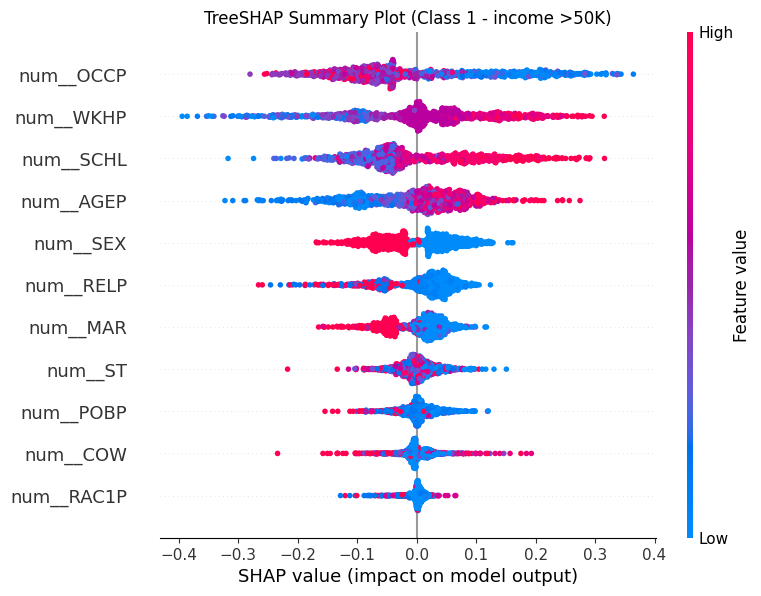

In [9]:
shap.summary_plot(shap_values[:, :, 1], X_sample_df, show=False)
plt.title("TreeSHAP Summary Plot (Class 1 - income >50K)")
# plt.savefig("shap_plots/summary_plot_class1.png")
# plt.close()

# Bar plot of average absolute SHAP values

print("SHAP plots saved to 'shap_plots/' directory.")

Text(0.5, 1.0, 'Feature Importance (SHAP)')

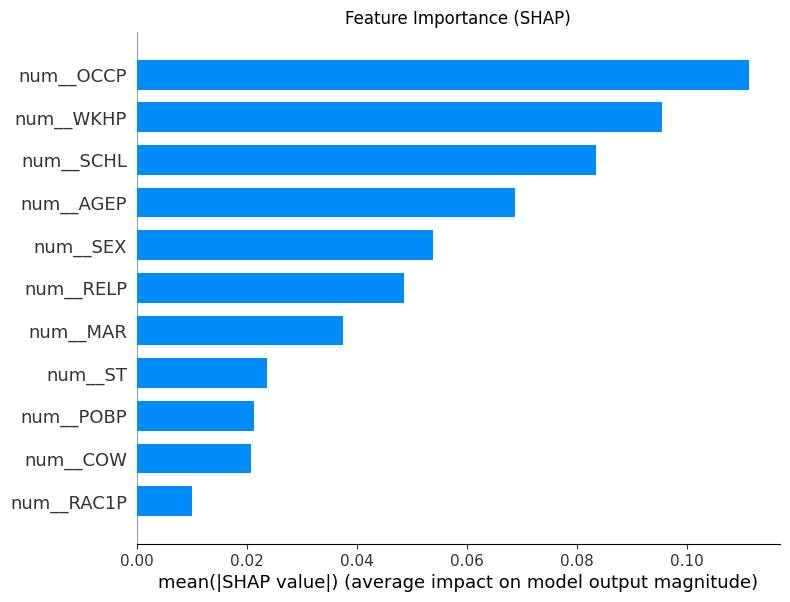

In [10]:
shap.summary_plot(shap_values[:,:,1], X_sample_df, plot_type="bar", show=False)
plt.title("Feature Importance (SHAP)")
# plt.savefig("shap_plots/feature_importance_class1.png")
# plt.close()


In [11]:
import numpy as np
sample = X_test.iloc[[0]]
shap_vals = explainer.shap_values(sample)[:,:,1]  # For class 1
print(shap_vals.shape)

# Flatten to 1D
shap_vals_1d = shap_vals.flatten()

# Rank features by importance
feature_order = np.argsort(-np.abs(shap_vals_1d))
X_modified = sample.copy()

preds = []
for i in range(len(feature_order)):
    # Set the i-th most important feature to its mean (or mode for categorical)
    col = sample.columns[feature_order[i]]
    if col in numerical_cols:
        X_modified[col] = X_train[col].mean()
    else:
        X_modified[col] = X_train[col].mode()[0]
    pred = rf_pipeline.predict_proba(X_modified)[0,1]
    preds.append(pred)

(1, 11)


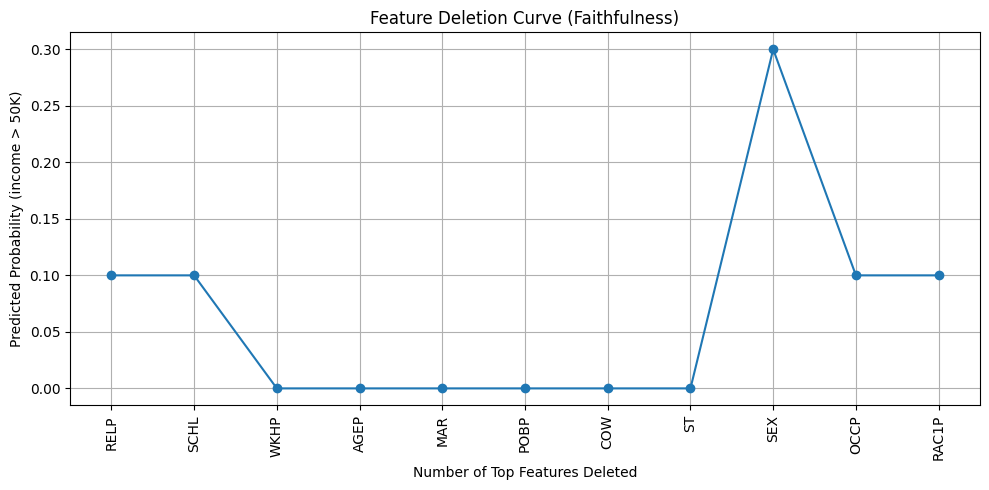

In [12]:
import matplotlib.pyplot as plt

# preds: list of predicted probabilities after each feature is set to baseline
# feature_order: indices of features in order of importance

# For x-axis labels, get feature names in deletion order
deleted_features = [sample.columns[i] for i in feature_order]

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(preds)+1), preds, marker='o')
plt.xlabel('Number of Top Features Deleted')
plt.ylabel('Predicted Probability (income > 50K)')
plt.title('Feature Deletion Curve (Faithfulness)')
plt.xticks(ticks=range(1, len(preds)+1), labels=deleted_features, rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
sample = X_test.iloc[[0]]
perturbed = sample.copy()
perturbed[numerical_cols] += np.random.normal(0, 0.01, size=(1, len(numerical_cols)))

shap_orig = explainer.shap_values(sample)[:,:,1]
shap_pert = explainer.shap_values(perturbed)[:,:,1]

stability = np.linalg.norm(shap_orig - shap_pert)
print("Stability:", stability)

Stability: 0.0


In [21]:
import shap
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Sample background for SHAP
X_background = shap.utils.sample(X_train, 100, random_state=42)

# Set up SHAP explainer
explainer = shap.Explainer(rf_pipeline.predict, X_background)

# Select one instance to explain
instance = X_test.iloc[[0]]  # shape: (1, n_features)

# Generate SHAP explanation
shap_values = explainer(instance)

# Create local neighborhood manually around the instance
# Using Gaussian noise around instance (repeat the row with noise)
num_samples = 100
noise_std = 0.01  # you can tune this
local_X = pd.DataFrame(
    np.repeat(instance.values, num_samples, axis=0),
    columns=X_train.columns
)
local_X += np.random.normal(0, noise_std, local_X.shape)

# Predict using pipeline
y_pred_blackbox = rf_pipeline.predict(local_X)

# Fit local linear surrogate model
surrogate = LinearRegression()
surrogate.fit(local_X, y_pred_blackbox)

# Compute local fidelity (R²)
r2 = surrogate.score(local_X, y_pred_blackbox)
print("Local fidelity (R²):", r2)



Local fidelity (R²): 1.0
